In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

# 进入某个路径
os.chdir('/content/drive/MyDrive/vessel_seg')

Mounted at /content/drive


In [3]:
filename = '020.npz'
artery = np.load('./dataset/label/artery/'+filename)
vein = np.load('./dataset/label/vein/'+filename)
raw = np.load('./dataset/input/'+filename)

img = raw.get("data")  # shape = (H, W, D) 或 (D, H, W)
artery = artery.get('data')
vein = vein.get('data')

print(img.shape) #(512, 512, 258)
print(artery.shape)
print(vein.shape)

(512, 512, 288)
(512, 512, 288)
(512, 512, 288)


In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.6 MB/s eta 0:00:00


In [ ]:
df = pd.read_excel("./dataset/metadata.xlsx")
res_str = df[df['CT scan'] == filename]['Resolution'].values[0]
original_spacing = tuple(ast.literal_eval(res_str))
original_spacing = (original_spacing[2], original_spacing[0], original_spacing[1])
print(original_spacing)

# 转成 SimpleITK.Image
sitk_img = sitk.GetImageFromArray(artery)
# 设置 spacing
sitk_img.SetSpacing(original_spacing)

# 目标 spacing
new_spacing = (1.0, 1.0, 1.0)

# 计算新的尺寸
original_size = sitk_img.GetSize()
new_size = [
    int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
    for i in range(3)
]

resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing(new_spacing)  # 改 spacing
resampler.SetSize(new_size)              # 同时改体素数量
resampler.SetInterpolator(sitk.sitkLinear)
new_img = resampler.Execute(sitk_img)
img_np = sitk.GetArrayFromImage(new_img)



(1.0, 0.6464844, 0.6464844)


In [ ]:
img_np = sitk.GetArrayFromImage(new_img)[None]

In [ ]:
img_np.shape

(1, 331, 331, 258)

In [ ]:
unique_vals = np.unique(img)
print(unique_vals)

[-1024 -1023 -1022 ...  3069  3070  3071]


In [ ]:
artery

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
print(new_img.GetSize())  # 体素数量 -> 不变
print(new_img.GetSpacing())  # 物理尺寸 -> 变成你设的

(512, 167, 331)
(1.0, 1.0, 1.0)


In [ ]:
new_img

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x795deaea4300> >

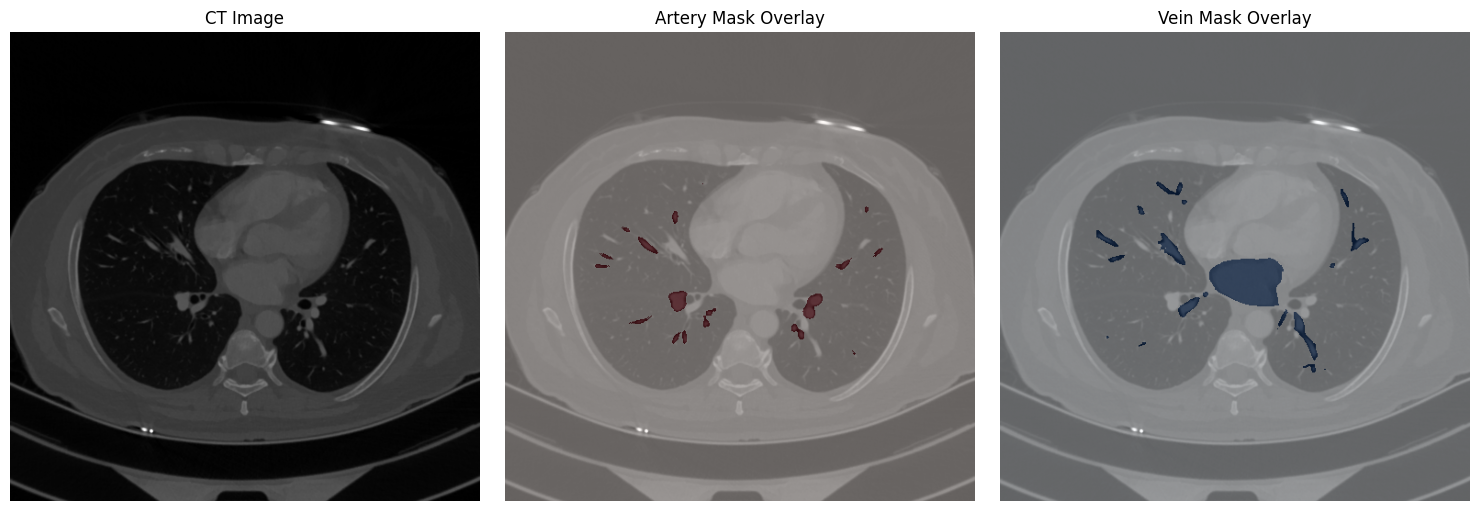

In [ ]:
# 选择第 d 层切片（可以调整）
d = img.shape[-1] // 2  # 中间一层
slice_img = img[:, :, d]
slice_artery = artery[:, :, d] if artery is not None else None
slice_vein = vein[:, :, d] if vein is not None else None

# 显示图像
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap='gray')
plt.title('CT Image')
plt.axis('off')

if slice_artery is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_artery, alpha=0.4, cmap='Reds')  # 红色叠加
    plt.title('Artery Mask Overlay')
    plt.axis('off')

if slice_vein is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_vein, alpha=0.4, cmap='Blues')  # 蓝色叠加
    plt.title('Vein Mask Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

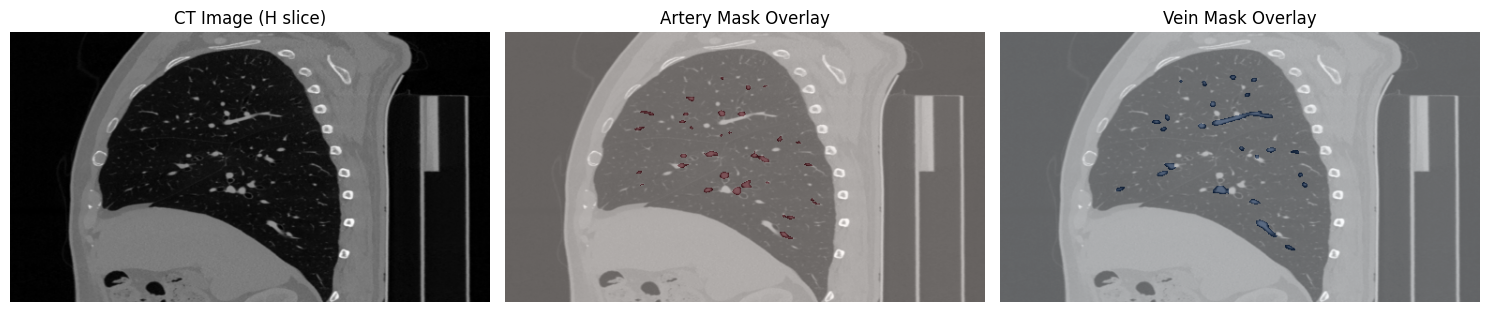

In [6]:
# 假设 h 是你想看的切片索引（高度方向）
h = img.shape[1] // 3  # 举例选中间层

# 取切片并旋转 90 度
slice_img = np.rot90(img[:, h, :])       # 注意这里第二维是 h，切片是二维数组 (W, D)
slice_artery = np.rot90(artery[:, h, :]) if artery is not None else None
slice_vein = np.rot90(vein[:, h, :]) if vein is not None else None

# 显示图像
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap='gray')
plt.title('CT Image (H slice)')
plt.axis('off')

if slice_artery is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_artery, alpha=0.4, cmap='Reds')  # 红色叠加
    plt.title('Artery Mask Overlay')
    plt.axis('off')

if slice_vein is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_vein, alpha=0.4, cmap='Blues')  # 蓝色叠加
    plt.title('Vein Mask Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()


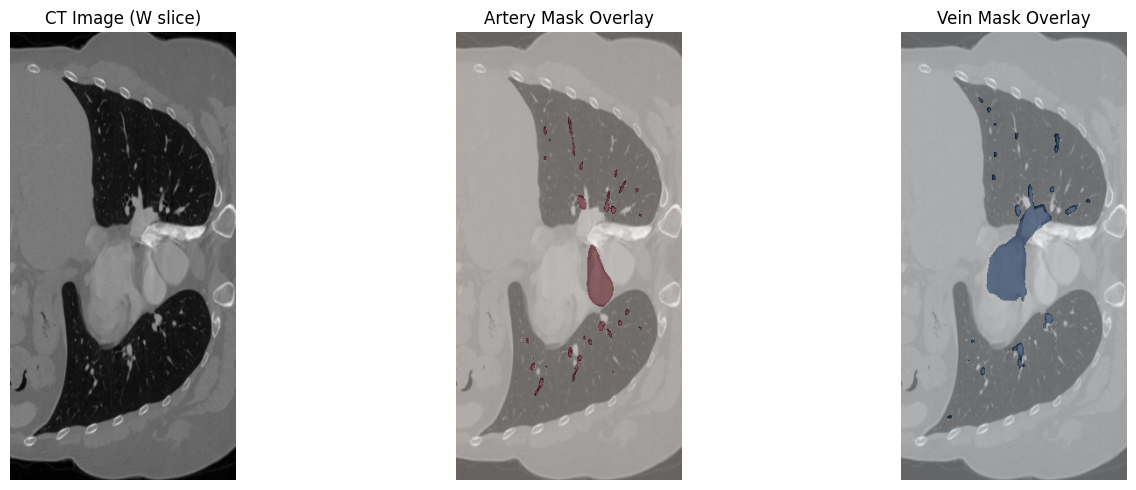

In [ ]:
# 假设 w 是你想看的切片索引（宽度方向）
w = img.shape[0] // 2  # 举例选中间层

slice_img = img[w, :, :]       # 取第一个维度的第 w 层，得到 (H, D)
slice_artery = artery[w, :, :] if artery is not None else None
slice_vein = vein[w, :, :] if vein is not None else None

# 显示图像
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap='gray')
plt.title('CT Image (W slice)')
plt.axis('off')

if slice_artery is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_artery, alpha=0.4, cmap='Reds')  # 红色叠加
    plt.title('Artery Mask Overlay')
    plt.axis('off')

if slice_vein is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_vein, alpha=0.4, cmap='Blues')  # 蓝色叠加
    plt.title('Vein Mask Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()


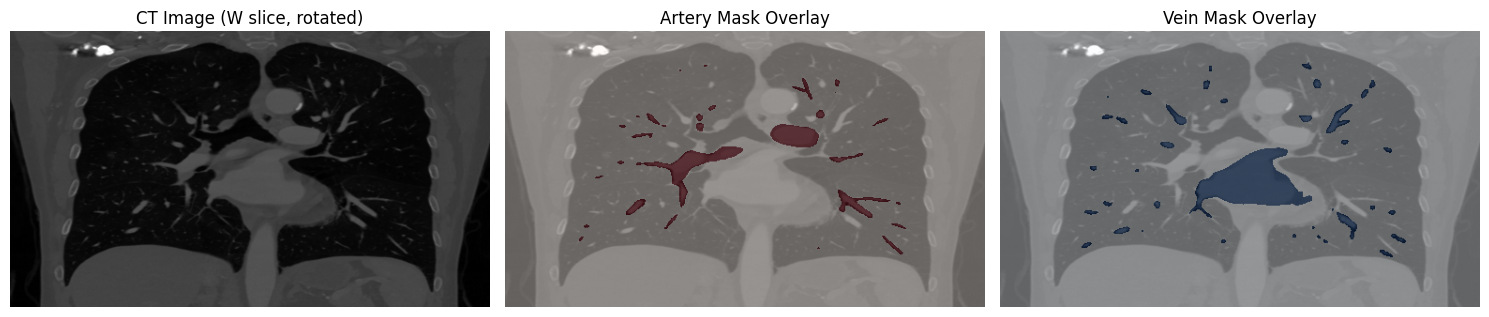

In [ ]:
# 假设 w 是你想看的切片索引（宽度方向）
w = img.shape[0] // 2  # 举例选中间层

# 取切片并旋转 90 度
slice_img = np.rot90(img[w, :, :])
slice_artery = np.rot90(artery[w, :, :]) if artery is not None else None
slice_vein = np.rot90(vein[w, :, :]) if vein is not None else None

# 显示图像
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap='gray')
plt.title('CT Image (W slice, rotated)')
plt.axis('off')

if slice_artery is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_artery, alpha=0.4, cmap='Reds')
    plt.title('Artery Mask Overlay')
    plt.axis('off')

if slice_vein is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_vein, alpha=0.4, cmap='Blues')
    plt.title('Vein Mask Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()


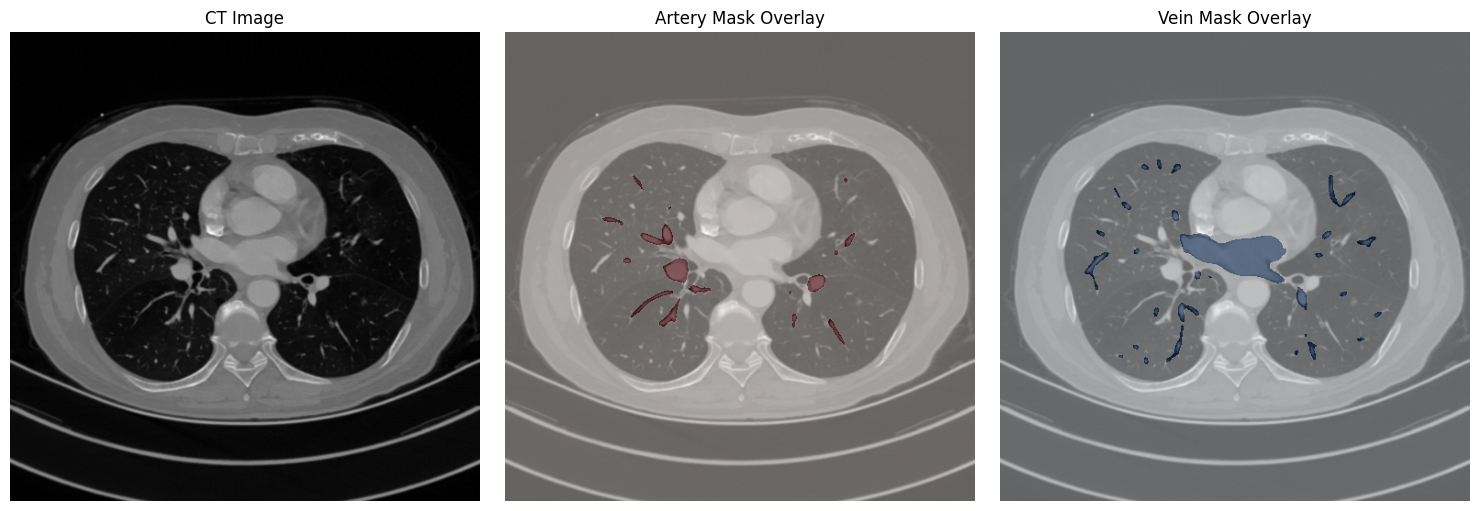

In [ ]:
filename = '002.npz'
artery = np.load('./dataset/label/artery/'+filename)
vein = np.load('./dataset/label/vein/'+filename)
raw = np.load('./dataset/input/'+filename)

# 加载图像
img = raw.get("data")  # shape = (H, W, D) 或 (D, H, W)
artery = artery.get('data')
vein = vein.get('data')

# 选择第 d 层切片（可以调整）
d = img.shape[-1] // 2  # 中间一层
slice_img = img[:, :, d]
slice_artery = artery[:, :, d] if artery is not None else None
slice_vein = vein[:, :, d] if vein is not None else None

# 显示图像
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap='gray')
plt.title('CT Image')
plt.axis('off')

if slice_artery is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_artery, alpha=0.4, cmap='Reds')  # 红色叠加
    plt.title('Artery Mask Overlay')
    plt.axis('off')

if slice_vein is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(slice_vein, alpha=0.4, cmap='Blues')  # 蓝色叠加
    plt.title('Vein Mask Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()